In this notebook, we study the effect of the interpolative decomposition (ID) of the Green's kernels that define the non-interacting Influence Functional (IF).

The Green's function is given by 
\begin{equation}
g(t_i)=\int_{-\infty}^\infty d\omega\, e^{i\omega t_i} \cdot \Big(1 - n_F(\omega)\Big) \cdot \Gamma(\omega), \tag{1}
\end{equation} 
where $t_i = \delta t \cdot n,\quad n \in \mathbb{N}^+.$

We discretize the (positive) frequencies as 
$$\omega_k = \exp\Big(h\cdot k - e^{-h\cdot k}\Big),$$
where $h > 0$ is the discretization parameter. 

Furthermore, we rotate all frequency points by an angle $\phi$ in the complex plane, i.e.
\begin{equation}
\tilde{\omega}_k \equiv  \omega_k e^{i \phi}, \tag{2}
\end{equation} 
where we choose $\phi = \pi/4.$

We separately analyse the two contributions $g(t_i) = g^+(t_i) + g^-(t_i)$ for each quadrant in the complex plane, where we denote $g^+(t_i)$ for $\text{Re}(\tilde{\omega}_k) \geq 0$ and $g^-(t_i)$ for $\text{Re}(\tilde{\omega}_k) < 0.$ We first focus on the former, which we can approximate as
\begin{equation}
g^+(t_i) \approx \sum\limits_{k=-n}^m \tilde{\omega}_k \cdot (h + h \cdot e^{-h\cdot k})\cdot e^{i\tilde{\omega}_k t_i}\cdot \Big(1 - n_F(\tilde{\omega}_k)\Big) \cdot \Gamma(\tilde{\omega}_k). \tag{3}
\end{equation} 
We define the discretization error $\epsilon_{discr}$ as the difference between Eq. (3) for finite $h$ and for $h \to 0,$ both in the limit $\frac{m}{h},\frac{n}{h} \to \infty.$

Each complex frequency represents one bath mode. In the following, we will study how many of these bath modes are needed in order to represent the partial Green's function $g^+(t_i)$ to a given accuracy.

The main object is the kernel matrix $K$, whose elements $K_{i,k}$ are given by:
\begin{equation}
K_{i,k} = \tilde{\omega}_k \cdot (h + h \cdot e^{-h\cdot k})\cdot e^{i\tilde{\omega}_k t_i}\cdot \Big(1 - n_F(\tilde{\omega}_k)\Big). \tag{4}
\end{equation}

In this discretized scheme, one thus has:
\begin{equation}
g^+(t_i) \approx\sum\limits_{k=-n}^m K_{i,k} \Gamma(\tilde{\omega}_k).  \tag{5}
\end{equation}

The ID of the kernel matrix $K$ reads:
\begin{equation}
K = B \cdot P + E,  \tag{6}
\end{equation}
where the error is bounded by $||E||_2 \leq \epsilon.$ (add reference..)
Importantly, by the properties of ID, the columns of $B$ are selected columns of $K.$ The ID-rank is the number of rows of $B.$

Generate the data by running "python3 -m src.generate_data.generate_ID_kernel." This generates a hdf5 file in "/data", which we analyze here.


In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Project Path Setup
from setup_project_path import check_and_add_project_path  # Script to check and add project path
check_and_add_project_path()

# Import Custom Modules
from src.utils.module_utils.all_custom_modules import cf, DataInterp, Hdf5Kernel, fit_logarithmic, log_func # Consolidated custom modules import


Project path successfully added.


Create instance of Hdf5Kernel which is associated with the specified Hdf5 file

In [2]:
filename = f'../data/delta_t=0.1.h5'
#Create instance of Hdf5Kernel
h5_kernel = Hdf5Kernel(filename=filename)

The Hdf5 file holds different point groups, each associated with one combination of parameters (final time, beta, discretization parameters h,..).

Below, we read out the file and create data arrays that hold the value of one quantity for all point groups, respectively. 

Our goal is to analyse and visualize these data arrays in the plot scripts below.

In [3]:
#Extract the relevant data for plotting from hdf5 file. Assemble it conveniently into multidimensional arrays.
data_h5, kernel_dims = h5_kernel.read_to_array()

errors = data_h5["errors"]
m_vals = data_h5["m_vals"]
n_vals = data_h5["n_vals"]
h_vals = data_h5["h_vals"]
N_maxs = data_h5["N_maxs"]
betas = data_h5["betas"]
delta_t_vals = data_h5["delta_t_vals"]
ID_ranks = data_h5["ID_ranks"]

nbr_modes_total = m_vals + n_vals
print(f"Dimensions of data arrays: {kernel_dims}.")


Dimensions of data arrays: [15 10  4].


Set some global plot parameters to each a clear and uniform layout.

In [4]:
#Set global plot parameters
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})

First, we want to analyze how the number of bath modes depend on the discretization parameter $h$, as well as on the error $\epsilon$. 

For this, we plot:

i) The number of bare modes: These are the modes that one obtains by choosing a discrete frequency parametrization in the complex plane. In this case, the error $\epsilon$ is simply the discretization error, $\epsilon = \epsilon_{discr},$ with respect to the continuous frequency integration result. $m$ and $n$ denote the number of modes for frequencies $|\omega| > 1/e$ and $|\omega| < 1/e,$ respectively.

ii) The ID-rank: This is the number of columns of B after interpolative decomposition (ID). It represents the effective number of modes to which the bath can be reduced while keeping the effective error on the order or magnitude of the discretization error, i.e. $\epsilon \sim \epsilon_{discr}.$

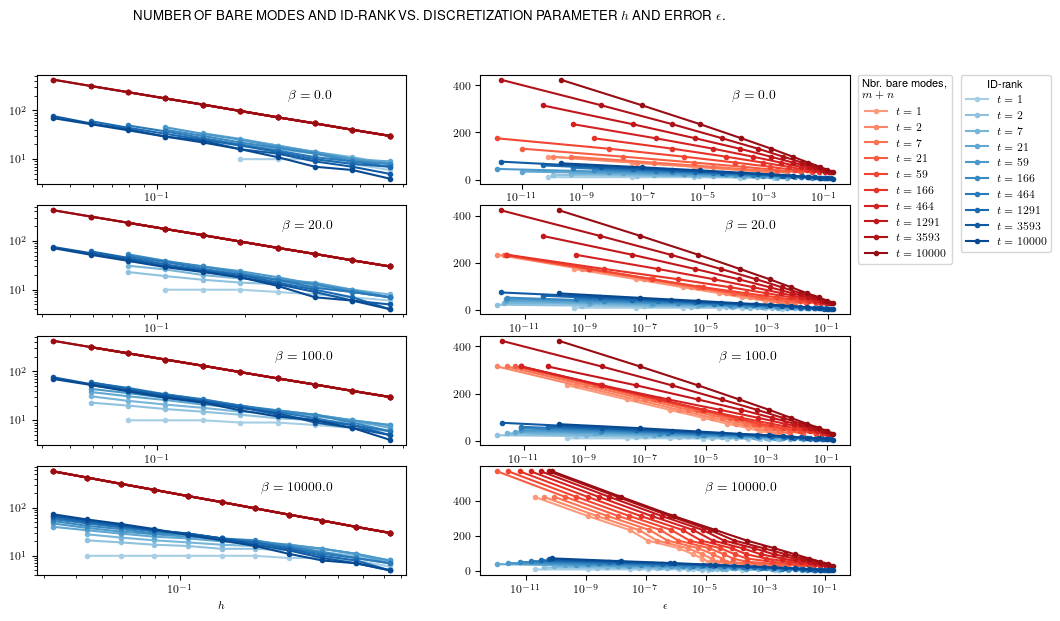

In [5]:
#_____Plot the number of modes versus the error and the discretization parameter h____
fig, axs = plt.subplots(kernel_dims[2], 2, figsize=(10.5, 6.5))
fig.suptitle(f'NUMBER OF BARE MODES AND ID-RANK VS. DISCRETIZATION PARAMETER $h$ AND ERROR $\epsilon$.')

cmaps = [plt.get_cmap("Blues"), plt.get_cmap("Reds")]
colors_blue = cmaps[0](np.linspace(0.35, 0.9, kernel_dims[1]))
colors_orange = cmaps[1](np.linspace(0.35, 0.9, kernel_dims[1]))

for b in range (kernel_dims[2]):
    for tau in range (kernel_dims[1]):
        mask = errors[:,tau,b] > 1.e-12#mask to filter values that are zero (i.e. no value avaliable)
        
        axs[b,0].plot(h_vals[mask, tau, b],nbr_modes_total[mask,tau,b],color=colors_orange[tau],marker="o",linestyle="-",markersize=3, label = r'$t={}$'.format(int(np.max(N_maxs[:,tau,:] * delta_t_vals[:,tau,:]))))
        axs[b,0].plot(h_vals[mask, tau, b], ID_ranks[mask,tau,b], color=colors_blue[tau], marker="o", linestyle="-", markersize=3)

        axs[b,1].plot(errors[mask, tau, b],nbr_modes_total[mask,tau,b] ,color=colors_orange[tau],marker="o",linestyle="-",markersize=3)
        axs[b,1].plot(errors[mask, tau, b], ID_ranks[mask,tau,b], color=colors_blue[tau], marker="o", linestyle="-", markersize=3, label = r'$t={}$'.format(int(np.max(N_maxs[:,tau,:] * delta_t_vals[:,tau,:]))))


    axs[b, 0].set_title(r'$\beta = {}$'.format(betas[0,0,b]), loc='right', x=.8, y=0.7)
    axs[b, 1].set_title(r'$\beta = {}$'.format(betas[0,0,b]), loc='right', x=.8, y=0.7)

    axs[b,0].set_yscale("log")   
    axs[b,0].set_xscale("log")  
    axs[b,1].set_xscale("log")

axs[-1,0].set_xlabel(r"$h$")
axs[-1,1].set_xlabel(r"$\epsilon$")

# Create legends and place them outside the rightmost subplot
legend1 = axs[0,0].legend(title=f'Nbr. bare modes,\n $m+n$', loc='upper left', bbox_to_anchor=(2.22, 1), borderaxespad=0.)
legend2 = axs[0,1].legend(title=f'ID-rank', loc='upper left', bbox_to_anchor=(1.3, 1), borderaxespad=0.)

#plt.savefig("../plots/modes_vs_error_no_opt.pdf", bbox_inches='tight')


Next, We study how the number of modes $m$ and $n$ scale with time for different fixed errors $\epsilon.$ 

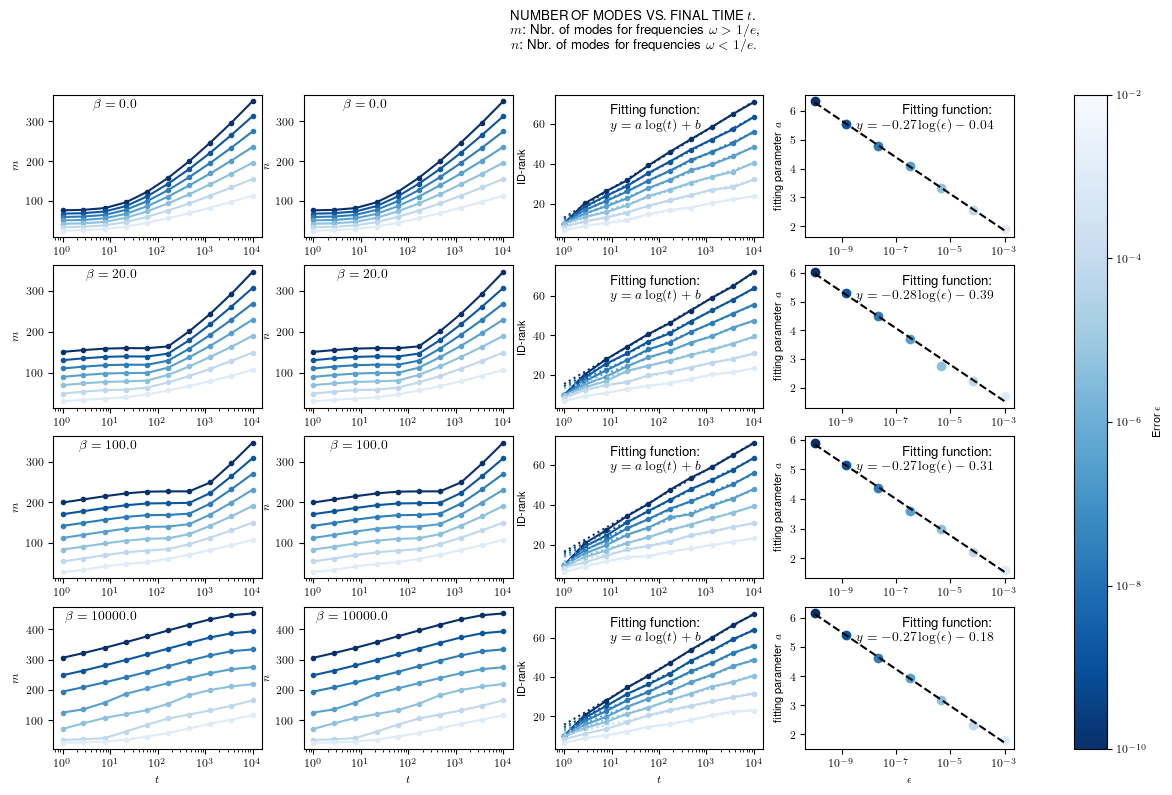

In [6]:
cmap = plt.get_cmap("Blues_r")
cmap_reds = plt.get_cmap("Reds_r")
# Configuration and data preparation
error_grid = np.logspace(-10, -3, 7)
colors = cmap(np.linspace(0.35, 0.9, len(error_grid)))

fig, axs = plt.subplots(kernel_dims[2], 4, figsize=(15.5, 8.5))
fig.suptitle(f'NUMBER OF MODES VS. FINAL TIME $t$.\n $m$: Nbr. of modes for frequencies $\omega > 1/e$,\n $n$: Nbr. of modes for frequencies $\omega < 1/e.$')

    

n_vals_interp = np.zeros((len(error_grid), kernel_dims[1]))
m_vals_interp = np.zeros((len(error_grid), kernel_dims[1]))
ID_ranks_interp = np.zeros((len(error_grid), kernel_dims[1]))

t_data = np.array([np.max(N_maxs[:,tau,:] * delta_t_vals[:,tau,:]) for tau in range (kernel_dims[1])])


# Use logarithmic normalization
norm = mcolors.LogNorm(vmin=np.min(error_grid[error_grid > 0]), vmax=10*np.max(error_grid))



# Interpolation and plotting
for b in range (kernel_dims[2]):

    fitting_params_a = np.zeros((len(error_grid),))

    for tau in range (kernel_dims[1]):
        mask = errors[:,tau,b] > 0. # Mask to filter values clearly above machine precision
        N_VALS_INTERP = DataInterp(errors[mask, tau,b], n_vals[mask, tau,b])
        M_VALS_INTERP = DataInterp(errors[mask, tau,b], m_vals[mask, tau,b])
        ID_RANKS_INTERP = DataInterp(errors[mask, tau,b], ID_ranks[mask, tau,b])

        n_vals_interp[:, tau] = N_VALS_INTERP.interp(error_grid, x_scale='log')
        m_vals_interp[:, tau] = M_VALS_INTERP.interp(error_grid, x_scale='log')
        ID_ranks_interp[:, tau] = ID_RANKS_INTERP.interp(error_grid, x_scale='log')
    
    
    for eps_iter, eps_val in enumerate(error_grid):
        label = f'${eps_val:.1e}$'  # Scientific notation for error values
        #plot only nonzero values
        mask_m = m_vals_interp[eps_iter, :] > 0.
        mask_n = n_vals_interp[eps_iter, :] > 0.

        axs[b,0].plot(t_data[mask_m], m_vals_interp[eps_iter, mask_m], marker="o", linestyle="-", markersize=3, color=cmap(norm(eps_val)), label=label)
        axs[b,1].plot(t_data[mask_n], m_vals_interp[eps_iter, mask_n], marker="o", linestyle="-", markersize=3, color=cmap(norm(eps_val)), label=label)
        axs[b,2].plot(t_data[mask_n], ID_ranks_interp[eps_iter, mask_n], marker="o", linestyle="-", markersize=3, color=cmap(norm(eps_val)), label=label)
        
        #fit logarithmic curves
        params = fit_logarithmic(t_data[mask_m][3:], ID_ranks_interp[eps_iter, mask_m][3:])
        fitting_params_a[eps_iter] = params[0]

        axs[b,2].plot(t_data[mask_m], log_func(t_data[mask_m], *params),  color=cmap(norm(eps_val)), linestyle = 'dotted')
        
    
        #plot fitting parameters
        axs[b,3].scatter(eps_val, params[0], marker="o",  color=cmap(norm(eps_val)), label = r'$a$')
        #axs[b,3].scatter(eps_val, params[1], marker="o",  color=cmap_reds(norm(eps_val)), label = r'$b$')

    a_fitting_params= fit_logarithmic(error_grid, fitting_params_a)

    axs[b,3].plot(error_grid, log_func(error_grid,*a_fitting_params), color = 'black', linestyle = 'dashed')

    axs[b, 0].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='right', x = .4, y=0.85)
    axs[b, 1].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='right', x = .4, y=0.85)
    axs[b, 2].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='right', x = .4, y=0.85)
    axs[b, 2].set_title("Fitting function: \n" + r'$y = a \log (t) + b$', loc='right', x = .7, y=0.7)
    axs[b, 3].set_title("Fitting function: \n" + r'$y = {} \log (\epsilon) {}$'.format(*np.round(a_fitting_params,2)), loc='right', x = .9, y=0.7)
    

    axs[b,0].set_ylabel(r'$m$')
    axs[b,1].set_ylabel(r'$n$')
    axs[b,2].set_ylabel('ID-rank')
    axs[b,3].set_ylabel("fitting parameter " + r'$a$')
  

    axs[b,0].set_xscale('log')
    axs[b,1].set_xscale('log')
    axs[b,2].set_xscale('log')

    axs[b,3].set_xscale('log')


    
# Setting labels and legend
axs[-1,0].set_xlabel(r'$t$')
axs[-1,1].set_xlabel(r'$t$')
axs[-1,2].set_xlabel(r'$t$')
axs[-1,3].set_xlabel(r'$\epsilon$')




# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is necessary because we're not using sm with imshow or similar
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label('Error '+r'$\epsilon$')

#axs[0,1].legend(title='Error ' + r'$\epsilon:$', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
#plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to fit the legend

#plt.savefig("../plots/modes_vs_time_no_opt.pdf", bbox_inches='tight')


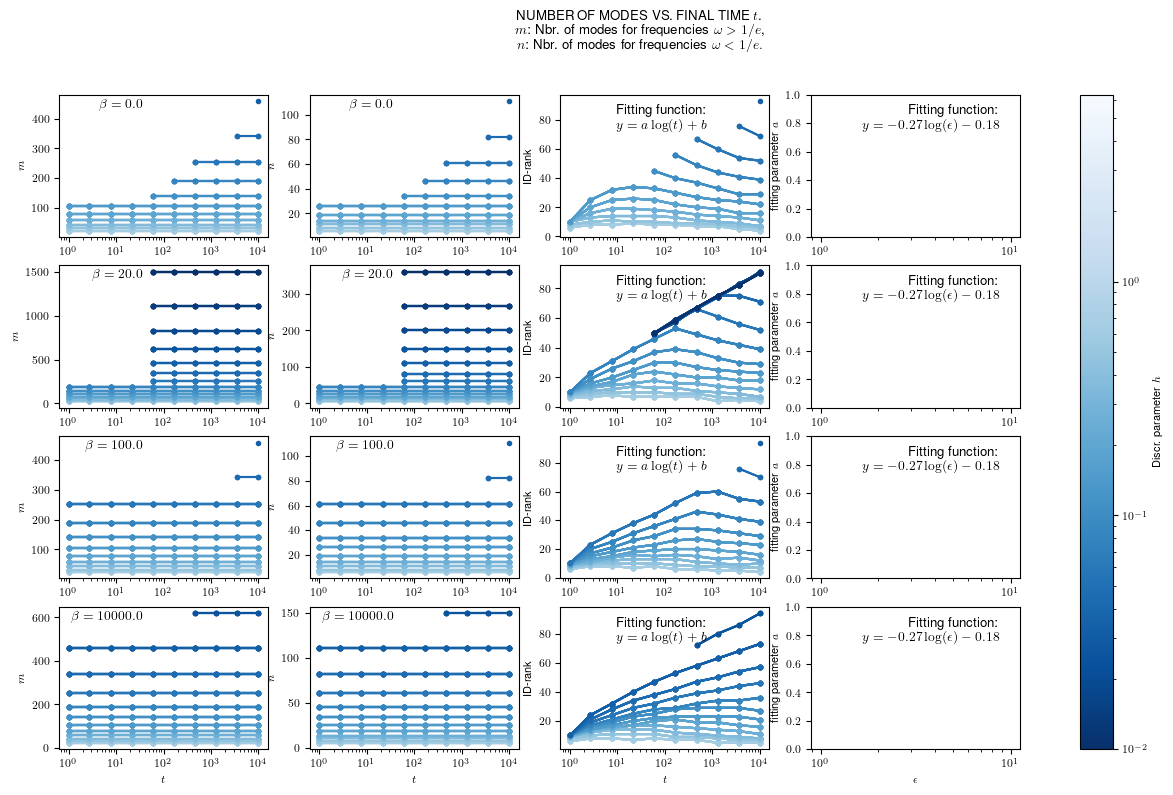

In [7]:
cmap = plt.get_cmap("Blues_r")
cmap_reds = plt.get_cmap("Reds_r")
# Configuration and data preparation
error_grid = np.logspace(-10, -3, 7)
colors = cmap(np.linspace(0.35, 0.9, len(error_grid)))

fig, axs = plt.subplots(kernel_dims[2], 4, figsize=(15.5, 8.5))
fig.suptitle(f'NUMBER OF MODES VS. FINAL TIME $t$.\n $m$: Nbr. of modes for frequencies $\omega > 1/e$,\n $n$: Nbr. of modes for frequencies $\omega < 1/e.$')

    

#elementwise multiplication
t_data = N_maxs * delta_t_vals


# Use logarithmic normalization
norm = mcolors.LogNorm(vmin=np.min(h_vals[h_vals > 0]), vmax=10*np.max(h_vals))



# Interpolation and plotting
for b in range (kernel_dims[2]):

    for tau in range (kernel_dims[1]):
    
        for h,h_val in enumerate(h_vals[:,tau, b]):

            if h_val > 0:
                mask = t_data[h, : , b ] > 0
                axs[b,0].plot(t_data[h, mask , b], m_vals[h, mask , b], marker="o", linestyle="-", markersize=3, color=cmap(norm(h_val)), label=label)
                axs[b,1].plot(t_data[h, mask , b], n_vals[h, mask , b], marker="o", linestyle="-", markersize=3, color=cmap(norm(h_val)), label=label)
                axs[b,2].plot(t_data[h, mask , b], ID_ranks[h, mask , b], marker="o", linestyle="-", markersize=3, color=cmap(norm(h_val)), label=label)
            
            else:
                continue
            
        #fit logarithmic curves
        #params = fit_logarithmic(t_data[mask_m][3:], ID_ranks_interp[eps_iter, mask_m][3:])
        #fitting_params_a[eps_iter] = params[0]

        #axs[b,2].plot(t_data[mask_m], log_func(t_data[mask_m], *params),  color=cmap(norm(eps_val)), linestyle = 'dotted')
        
    
        #plot fitting parameters
        #axs[b,3].scatter(eps_val, params[0], marker="o",  color=cmap(norm(eps_val)), label = r'$a$')
        #axs[b,3].scatter(eps_val, params[1], marker="o",  color=cmap_reds(norm(eps_val)), label = r'$b$')

    #a_fitting_params= fit_logarithmic(error_grid, fitting_params_a)

    #axs[b,3].plot(error_grid, log_func(error_grid,*a_fitting_params), color = 'black', linestyle = 'dashed')

    axs[b, 0].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='right', x = .4, y=0.85)
    axs[b, 1].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='right', x = .4, y=0.85)
    axs[b, 2].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='right', x = .4, y=0.85)
    axs[b, 2].set_title("Fitting function: \n" + r'$y = a \log (t) + b$', loc='right', x = .7, y=0.7)
    axs[b, 3].set_title("Fitting function: \n" + r'$y = {} \log (\epsilon) {}$'.format(*np.round(a_fitting_params,2)), loc='right', x = .9, y=0.7)
    

    axs[b,0].set_ylabel(r'$m$')
    axs[b,1].set_ylabel(r'$n$')
    axs[b,2].set_ylabel('ID-rank')
    axs[b,3].set_ylabel("fitting parameter " + r'$a$')
  

    axs[b,0].set_xscale('log')
    axs[b,1].set_xscale('log')
    axs[b,2].set_xscale('log')

    axs[b,3].set_xscale('log')


    
# Setting labels and legend
axs[-1,0].set_xlabel(r'$t$')
axs[-1,1].set_xlabel(r'$t$')
axs[-1,2].set_xlabel(r'$t$')
axs[-1,3].set_xlabel(r'$\epsilon$')




# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is necessary because we're not using sm with imshow or similar
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label('Discr. parameter '+r'$h$')

#axs[0,1].legend(title='Error ' + r'$\epsilon:$', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
#plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to fit the legend

#plt.savefig("../plots/modes_vs_time_no_opt.pdf", bbox_inches='tight')


/var/folders/cg/_38xw63s1fg5wbmw91yk0qzr0000gn/T/ipykernel_97253/1971952862.py:15: RuntimeWarning: divide by zero encountered in divide
  axs[b].plot(1 / np.log(1 / errors[:, tau, b]) , h_vals[:, tau, b], color = cmap(norm(t)))


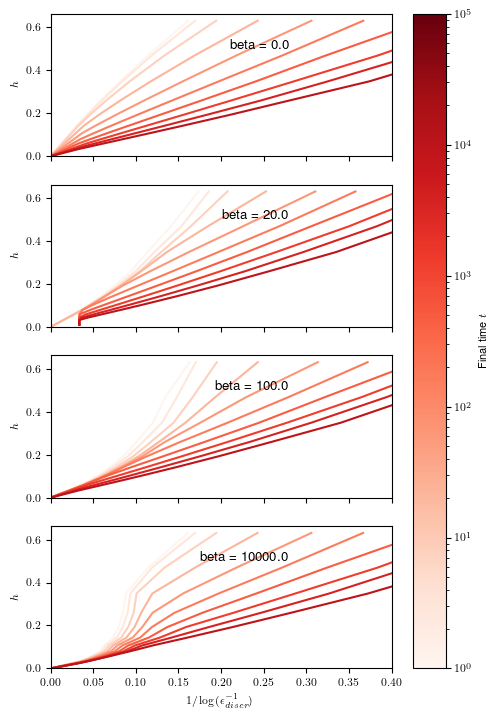

In [8]:
cmap = plt.get_cmap("Reds")

#elementwise multiplication
t_data = N_maxs * delta_t_vals

# Use logarithmic normalization
norm = mcolors.LogNorm(vmin=np.min(t_data[t_data > 0]), vmax=10*np.max(t_data))

fig, axs = plt.subplots(kernel_dims[2], figsize=(5.5, 8.5), sharex= True)

for b in range (kernel_dims[2]):
    beta = np.max(betas[:,:,b])
    for tau in range (kernel_dims[1]):
        t = np.max(t_data[:,tau,:])
        axs[b].plot(1 / np.log(1 / errors[:, tau, b]) , h_vals[:, tau, b], color = cmap(norm(t)))

        axs[b].set_ylabel(r'$h$')
        axs[b,].set_title(f'beta = {beta}', loc='right', x = .7, y=0.7)
        axs[b].set_ylim(bottom = 0)

axs[-1].set_xlabel(r"$1/\log(\epsilon_{discr}^{-1})$")
axs[-1].set_xlim(left = 0,right = .4)

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is necessary because we're not using sm with imshow or similar
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label('Final time '+r'$t$')

Study the scaling of the error $\epsilon$ with time. We do this, fixing the discretization parameter $h$.

[0.63095734 0.46927625 0.34902549 0.25958866 0.19306977 0.14359617
 0.10680004 0.07943282 0.05907838 0.04393971 0.03268028 0.02430604
 0.01807769 0.01344533 0.01      ]


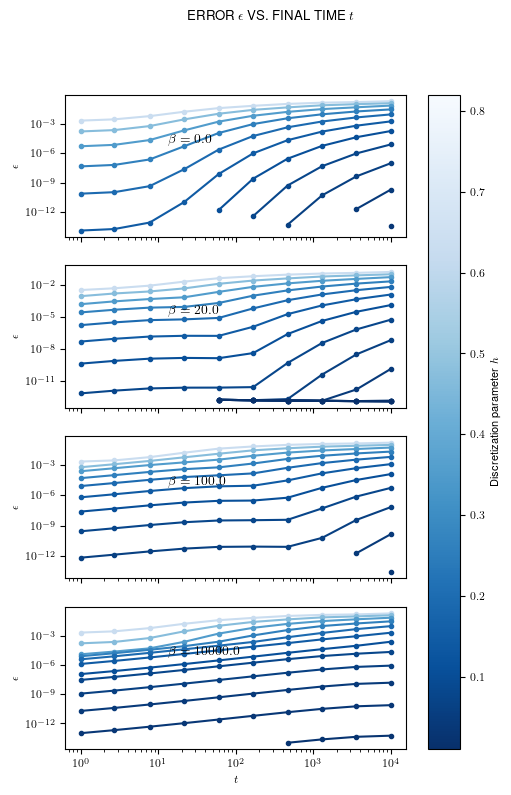

In [9]:
# Choose a colormap
cmap = plt.get_cmap('Blues_r')  

fig, axs = plt.subplots(kernel_dims[2], 1, figsize=(5.5, 8.5), sharex=True)
fig.suptitle(f'ERROR $\epsilon$ VS. FINAL TIME $t$')


t_data = np.array([np.max(N_maxs[:,tau,:] * delta_t_vals[:,tau,:]) for tau in range (kernel_dims[1])])


start_index = 0
h_vals_loop = np.array([np.max(h_vals[h,:,:]) for h in range (kernel_dims[0])])[start_index:]

print(h_vals_loop)
# Normalize h_val values to the 0-1 range
norm = mcolors.Normalize(vmin=np.min(h_vals_loop[h_vals_loop > 0.]), vmax=1.3*np.max(h_vals_loop))

for b in range (kernel_dims[2]):
    
    for h_idx, h_val in enumerate(h_vals_loop):
        
        mask = errors[h_idx + start_index,:,b] > 1.e-16
        axs[b].plot(t_data[mask], errors[h_idx + start_index,mask,b], color = cmap(norm(h_val)), marker="o",linestyle="-",markersize=3)
    

    axs[b].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='left', x=.3, y=.6)
    
    axs[b].set_ylabel(r'$\epsilon$')
    axs[b].set_yscale('log')

axs[-1].set_xlabel(r'$t$')
axs[-1].set_xscale('log')



# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is necessary because we're not using sm with imshow or similar
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label('Discretization parameter '+r'$h$')

#plt.savefig("../plots/error_vs_time_no_opt.pdf", bbox_inches='tight')


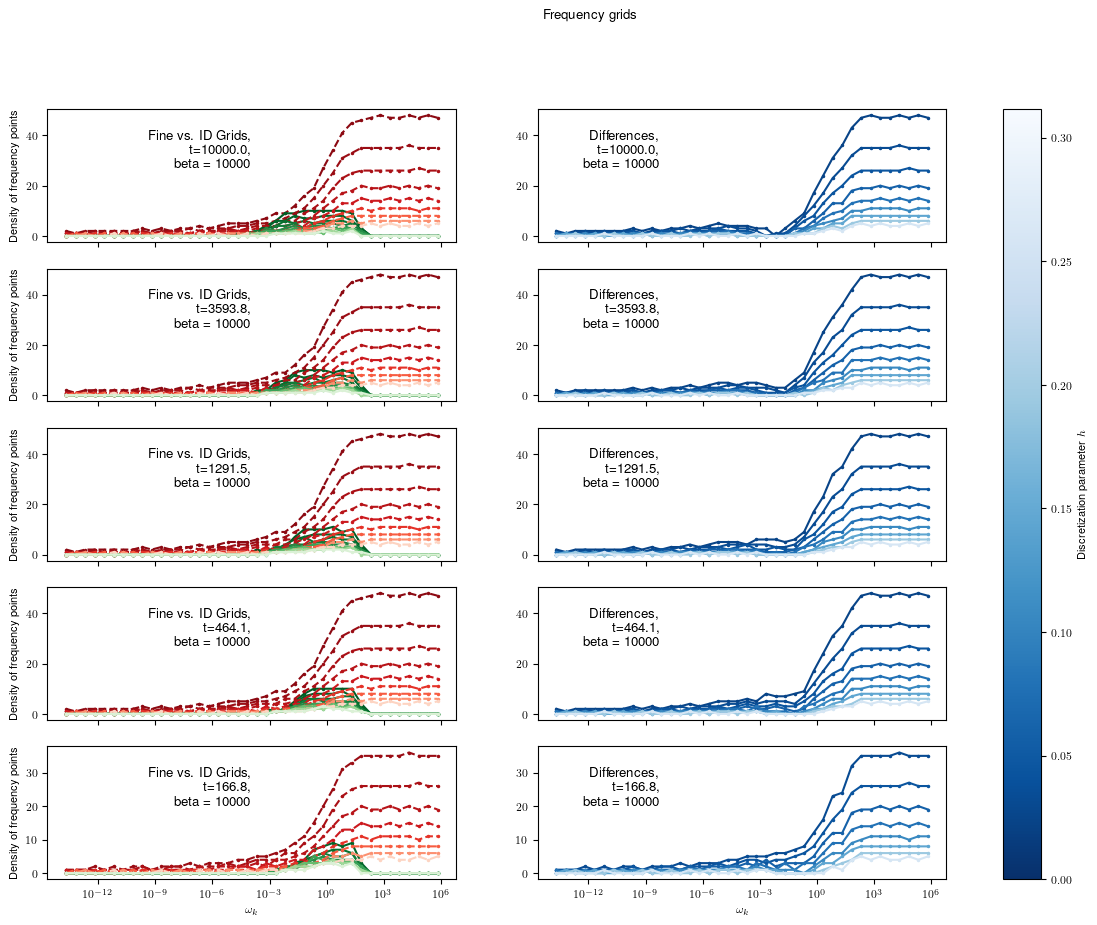

In [10]:
nbr_h_values = 12
nbr_taus = 5
# Choose a colormap
fig, axs = plt.subplots(nbr_taus, 2, figsize=(14.5, 2.*nbr_taus), sharex= True)
fig.suptitle(f'Frequency grids')
cmap_blues = plt.get_cmap('Blues_r') 
cmap_reds = plt.get_cmap('Reds_r') 
cmap_greens = plt.get_cmap('Greens_r') 


for tau in range (nbr_taus):
    #extract params and data for fixed final time and fixed beta
    params_array, data_array = np.array(list(zip(*[h5_kernel.read_kernel_element((kernel_dims[0]-1-i, kernel_dims[1]-1 - tau, kernel_dims[2]-1)) for i in range (nbr_h_values)])))

    h_vals = [params["h"] for params in params_array]
    fine_grids =  [data["fine_grid"] for data in data_array]
    coarse_grids =  [data["coarse_grid"] for data in data_array]

    min_h_val = np.min(h_vals)
    max_h_val = np.max(h_vals)

    # Normalize h_val values to the 0-1 range
    norm = mcolors.Normalize(vmin=min_h_val, vmax=1.2*max_h_val)

    lower_lim, upper_lim, interval_spacing = -14, 6, "log"


    for i, h_val in enumerate(h_vals):
        
        if h_val > 0:
            density_fine, density_fine_grid = cf.point_density(fine_grids[i], lower_lim, upper_lim, interval_spacing)
            density_coarse, density_coarse_grid = cf.point_density(coarse_grids[i], lower_lim, upper_lim, interval_spacing)
            density_diff, density_diff_grid = cf.point_density(np.setdiff1d(fine_grids[i], coarse_grids[i]), lower_lim, upper_lim, interval_spacing)


            axs[tau,0].plot(density_fine_grid, density_fine, marker = ".", linestyle = 'dashed', markersize = 3, color = cmap_reds(norm(h_val)))
            axs[tau,0].plot(density_coarse_grid, density_coarse, marker = ".", markersize = 3, color = cmap_greens(norm(h_val)))
            axs[tau,1].plot(density_diff_grid, density_diff, marker = ".", markersize = 3, color = cmap_blues(norm(h_val)))
                

        else:
            continue

    for ax in axs[tau,:]:
        ax.set_xscale("log")
        

    axs[tau,0].set_ylabel("Density of frequency points")

    axs[tau,0].set_title(f'Fine vs. ID Grids,\n t={params_array[-1]["delta_t"] * params_array[-1]["N_max"]},\n beta = {params_array[-1]["beta"]}', loc='right', x=.5, y=0.5)
    axs[tau,1].set_title(f'Differences,\n t={params_array[-1]["delta_t"] * params_array[-1]["N_max"]},\n beta = {params_array[-1]["beta"]}', loc='right', x=.3, y=0.5)

axs[-1,0].set_xlabel(r"$\omega_k$")
axs[-1,1].set_xlabel(r"$\omega_k$")

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap_blues, norm=norm)
sm.set_array([])  # This is necessary because we're not using sm with imshow or similar
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label('Discretization parameter '+r'$h$')

#plt.savefig("../plots/grids_no_opt_beta=10000.pdf", bbox_inches='tight')
